In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

In [4]:
epochs = 20
batch_size = 64
learning_rate = 0.01

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(), #Convert to tensor
    transforms.Normalize( (0.5,0.5,0.5) , (0.5,0.5,0.5) ) #Convert from 0-1 to -1-1 range make mean = 0
])

In [6]:
train_dataset = torchvision.datasets.CIFAR10(root = "./data",train = True, download = True,transform = transform)

In [7]:
test_dataset = torchvision.datasets.CIFAR10(root = "./data", train = False, transform = transform)

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = batch_size, shuffle = True)

In [9]:
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size, shuffle = False)

In [10]:
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

In [11]:
examples = iter(test_loader)
x,y = next(examples)
x.shape

torch.Size([64, 3, 32, 32])

In [12]:
x[0].shape

torch.Size([3, 32, 32])

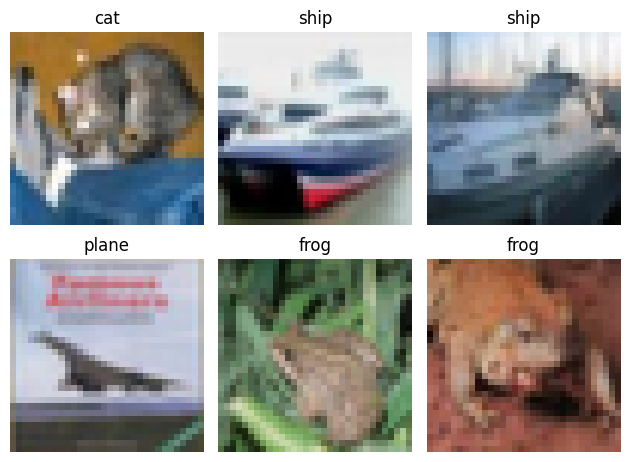

In [13]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.axis("off")
    img = x[i] / 2 + 0.5 #bringing it back to 0-1
    img = img.numpy().transpose(1,2,0) #Because currently 0-channel, 1-h ,2-w we want 1-h, 2-w, 0-channel to do imshow
    plt.imshow(img)
    plt.title(classes[y[i]])
plt.tight_layout()
plt.show()

In [14]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3) #input 3 , output 32 , kernel size 3 Goes from n,3,32,32 to n,32,30,30 (does -3 + 1)
        self.pool = nn.MaxPool2d(2,2) #n,c,h,w becomes n,c,h/2,w/2 so n,32,15,15
        self.conv2 = nn.Conv2d(32,64,3) #now its n,64,13,13
        self.conv3 = nn.Conv2d(64,64,3) #still n,64,
        self.fc1 = nn.Linear(64*4*4,64) #input is 1024 output is 64
        self.fc2 = nn.Linear(64,10) #returns 10 scores
    
    def forward(self,x):
        #n,3,32,32
        x = F.relu(self.conv1(x)) #n, 32, 30,30
        x = self.pool(x) #n,32,15,15
        x = F.relu(self.conv2(x)) #n,64,13,13
        x = self.pool(x) #n,64,6,6
        x = F.relu(self.conv3(x)) #n,64,4,4
        x = torch.flatten(x,1) #n,1024
        x = F.relu(self.fc1(x)) #n,64
        x = self.fc2(x) #n,10
        return x

In [15]:
model = ConvNet().to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [17]:
total_steps = len(train_loader)

for i in range(epochs):
    running_loss = 0.0
    
    for index,(images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images) #does forward pass
        loss = criterion(outputs,labels) #compute loss

        loss.backward() #calculates gradient
        optimizer.step() #update weights
        optimizer.zero_grad() #clear gradients

        running_loss += loss.item()
    
    print(f"Epoch ({i+1}): loss : {running_loss/total_steps} per batch")


print("Training over")

Epoch (1): loss : 1.7350998336396863 per batch
Epoch (2): loss : 1.549753765925727 per batch
Epoch (3): loss : 1.4917273904051622 per batch
Epoch (4): loss : 1.4495537163656387 per batch
Epoch (5): loss : 1.4408879714548741 per batch
Epoch (6): loss : 1.4235385154824123 per batch
Epoch (7): loss : 1.4122327630934508 per batch
Epoch (8): loss : 1.3985607072215556 per batch
Epoch (9): loss : 1.3992218628258961 per batch
Epoch (10): loss : 1.3915308160550148 per batch
Epoch (11): loss : 1.3816411826006896 per batch
Epoch (12): loss : 1.3808324859117913 per batch
Epoch (13): loss : 1.3810030793594887 per batch
Epoch (14): loss : 1.3744868075908603 per batch
Epoch (15): loss : 1.3599199591695195 per batch
Epoch (16): loss : 1.3527415656220272 per batch
Epoch (17): loss : 1.3424746779834522 per batch
Epoch (18): loss : 1.3449687213848924 per batch
Epoch (19): loss : 1.329173290668546 per batch
Epoch (20): loss : 1.3213990640152447 per batch
Training over


In [18]:
PATH = './cnn.pth'
torch.save(model.state_dict(),PATH) #save the trained parameters

In [19]:
loaded_model = ConvNet()
loaded_model.load_state_dict(torch.load(PATH)) #it takes the loaded dictionary not path file
loaded_model.to(device)
loaded_model.eval() #make it prepared for evaluation
model.eval()

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [20]:
len(test_loader.dataset)

10000

In [21]:
with torch.no_grad():
    correct = 0
    correct2 = 0
    samples = len(test_loader.dataset)

    for images,labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)

        _,predicted = torch.max(outputs,1)
        correct += (predicted == labels).sum().item()

        outputs2 = loaded_model(images)

        _,predicted2 = torch.max(outputs2, 1)
        correct2 += (predicted2 == labels).sum().item()

    acc = 100.0 * correct/samples
    acc2 = 100.0 * correct2/samples

    print(f"Accuracy of model = {acc}")
    print(f"Accuracy of loaded model = {acc2}")

Accuracy of model = 51.52
Accuracy of loaded model = 51.52
